# Introduction to Timeseries datasets

> Note: you will be best served by familiarizing yourself with the more basic notebooks _Introduction to Argovis_ and _Intro to Argovis' Grid API_ before following this notebook.

The generic point schema used by Argovis for point-like data such as Argo profiles and grids works well for data that can be feasilby captured as documents with unique latitude, longitude, and timestamps. However, when considering higher-resolution datasets, indexing independent documents for each such coordinate triple can dramatically exceed the scale of computing resources the point data above requires; for example, while Argo has roughly 3 million such profile documents to consider at the time of writing, a global, quarter-degree grid measured daily for 30 years (a typical scale for satellite products) would have on the order of *10 billion* such documents. In order to represent, index and serve such high-resolution grids on similar compute infrastructure to the point data, we make a minor modification to the generic point schema to form the *generic timeseries schema*:

 - Vectors in the ``data`` object represent surface measurements, estimates or flags as an ordered timeseries.
 - The ``data`` document no longer has a single ``timestamp`` key, as the data within corresponds to many timestamps.
 - The ``metadata`` or ``data`` document must bear a ``timeseries`` key, which is an ordered list of timestamps corresponding to the times associated with each element in the ``data`` vectors.

The observant reader will notice that this is very similar to the gridded products which have a ``levels`` key indicating the model depths for each entry in their ``data`` vectors. All other aspects of the generic schema remain consistent between point and timeseries datasets. In this notebook, we'll illustrate the unique features of a couple of timeseries datasets; for all other details, the reader is encouraged to apply what they learned from other Argovis API examples, as most query filters and behaviors remain identical between point and timeseries datasets.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for API_KEY in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [2]:
from argovisHelpers import helpers as avh
import helpers

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

# NOAA Sea surface temperature timeseries

Argovis indexes the weekly average sea surface temperature on a 1 degree grid as provided by NOAA via [https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html). Let's start by having a look at the metadata for this collection:

In [3]:
sstMetaQuery = {
    'id': 'noaa-oi-sst-v2' 
}

sstMeta = avh.query('timeseries/meta', options=sstMetaQuery, apikey=API_KEY, apiroot=API_ROOT)
print(sstMeta)

[{'_id': 'noaa-oi-sst-v2', 'data_type': 'noaa-oi-sst-v2', 'data_info': [['sst'], ['units', 'long_name'], [['degC', 'Weekly Mean of Sea Surface Temperature']]], 'date_updated_argovis': '2023-08-10T00:40:59.000Z', 'timeseries': ['1989-12-31T00:00:00.000Z', '1990-01-07T00:00:00.000Z', '1990-01-14T00:00:00.000Z', '1990-01-21T00:00:00.000Z', '1990-01-28T00:00:00.000Z', '1990-02-04T00:00:00.000Z', '1990-02-11T00:00:00.000Z', '1990-02-18T00:00:00.000Z', '1990-02-25T00:00:00.000Z', '1990-03-04T00:00:00.000Z', '1990-03-11T00:00:00.000Z', '1990-03-18T00:00:00.000Z', '1990-03-25T00:00:00.000Z', '1990-04-01T00:00:00.000Z', '1990-04-08T00:00:00.000Z', '1990-04-15T00:00:00.000Z', '1990-04-22T00:00:00.000Z', '1990-04-29T00:00:00.000Z', '1990-05-06T00:00:00.000Z', '1990-05-13T00:00:00.000Z', '1990-05-20T00:00:00.000Z', '1990-05-27T00:00:00.000Z', '1990-06-03T00:00:00.000Z', '1990-06-10T00:00:00.000Z', '1990-06-17T00:00:00.000Z', '1990-06-24T00:00:00.000Z', '1990-07-01T00:00:00.000Z', '1990-07-08T00:00

We can see from the usual `data_info` that this dataset contains one variable called `sst` corresponding to weekly mean sea surface temperature. A feature unique to timeseries datasets is that the metadata document (of which there is one per dataset) contains a `timeseries` key; this lists all the timesteps for all the timeseries in the dataset.

We can also have a look at a corresponding data document, ID'ed as `<longitude>_<latitude>`:

In [5]:
sstQuery = {
    'id': '14.5_39.5',
    'data': 'sst'
}

sst = avh.query('timeseries/noaasst', options=sstQuery, apikey=API_KEY, apiroot=API_ROOT)
print(sst)

[{'_id': '14.5_39.5', 'metadata': ['noaa-oi-sst-v2'], 'basin': 4, 'geolocation': {'type': 'Point', 'coordinates': [14.5, 39.5]}, 'data': [[15.64, 15.31, 15.1, 15.16, 15.33, 15.11, 14.71, 15.280000000000001, 15.22, 14.870000000000001, 15.33, 15.64, 15.780000000000001, 15.69, 15.56, 15.540000000000001, 15.91, 16.62, 17.85, 18.89, 20.31, 20.05, 20.55, 21.5, 22.67, 24.35, 25.34, 24.96, 25.79, 26.02, 27.09, 26.93, 26.98, 26.51, 25.97, 25.43, 25.01, 24.39, 23.78, 23.37, 23.13, 23.14, 22.55, 21.5, 20.57, 19.67, 19.37, 18.55, 17.02, 15.88, 15.9, 15.25, 15.44, 15.13, 14.63, 14.55, 14.47, 13.69, 14.02, 13.67, 13.75, 14.38, 14.44, 14.57, 15.200000000000001, 15.06, 15.55, 15.33, 15.290000000000001, 15.46, 15.85, 16.32, 16.990000000000002, 17.64, 18.75, 19.81, 21.7, 22.67, 22.39, 24.01, 24.93, 25.96, 25.09, 25.39, 26.69, 26.51, 26.96, 26.060000000000002, 25.400000000000002, 25.42, 25.43, 24.12, 23.04, 22.45, 21.490000000000002, 20.56, 19.64, 19.37, 18.53, 17.63, 16.84, 16.06, 15.42, 14.97, 14.70000

The `data` key here is structured according to `data_info` like all other Argovis datasets; the elements correspond to the timestamps in order as found on the metadata document.

If instead we provide a time range to our data query:

In [10]:
sstQuery = {
    'id': '14.5_39.5',
    'data': 'sst',
    'startDate': '1993-01-01T00:00:00Z',
    'endDate': '1993-02-01T00:00:00Z'
}

sst = avh.query('timeseries/noaasst', options=sstQuery, apikey=API_KEY, apiroot=API_ROOT)
print(sst)

[{'_id': '14.5_39.5', 'metadata': ['noaa-oi-sst-v2'], 'basin': 4, 'geolocation': {'type': 'Point', 'coordinates': [14.5, 39.5]}, 'data': [[15.05, 14.870000000000001, 14.99, 14.540000000000001, 14.67]], 'timeseries': ['1993-01-03T00:00:00.000Z', '1993-01-10T00:00:00.000Z', '1993-01-17T00:00:00.000Z', '1993-01-24T00:00:00.000Z', '1993-01-31T00:00:00.000Z'], 'data_info': [['sst'], ['units', 'long_name'], [['degC', 'Weekly Mean of Sea Surface Temperature']]]}]


we get a `timeseries` key appended to the data document to indicate the timestamps of the filtered timeseries; note this is in close analogy to how levels are filtered in Argovis' representation of Argo grids, for example.

# Copernicus sea level anomaly timeseries

Argovis indexes a quarter-degree grid of sea level anomalies and absolute dynamic topologies from [https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global); note that the original daily data reported at this link has been averaged down to weekly averages with timestamps aligned with the NOAA SST dataset described above, for scale and comparison purposes.

Let's again start by looking at the single metadata document for this collection:

In [7]:
slaMetaQuery = {
    'id': 'copernicusSLA' 
}

slaMeta = avh.query('timeseries/meta', options=slaMetaQuery, apikey=API_KEY, apiroot=API_ROOT)
print(slaMeta)

[{'_id': 'copernicusSLA', 'data_type': 'sea level anomaly', 'data_info': [['sla', 'adt'], ['units', 'long_name'], [['m', 'Sea level anomaly'], ['m', 'Absolute dynamic topography']]], 'date_updated_argovis': '2023-08-10T00:54:23.000Z', 'timeseries': ['1993-01-03T00:00:00.000Z', '1993-01-10T00:00:00.000Z', '1993-01-17T00:00:00.000Z', '1993-01-24T00:00:00.000Z', '1993-01-31T00:00:00.000Z', '1993-02-07T00:00:00.000Z', '1993-02-14T00:00:00.000Z', '1993-02-21T00:00:00.000Z', '1993-02-28T00:00:00.000Z', '1993-03-07T00:00:00.000Z', '1993-03-14T00:00:00.000Z', '1993-03-21T00:00:00.000Z', '1993-03-28T00:00:00.000Z', '1993-04-04T00:00:00.000Z', '1993-04-11T00:00:00.000Z', '1993-04-18T00:00:00.000Z', '1993-04-25T00:00:00.000Z', '1993-05-02T00:00:00.000Z', '1993-05-09T00:00:00.000Z', '1993-05-16T00:00:00.000Z', '1993-05-23T00:00:00.000Z', '1993-05-30T00:00:00.000Z', '1993-06-06T00:00:00.000Z', '1993-06-13T00:00:00.000Z', '1993-06-20T00:00:00.000Z', '1993-06-27T00:00:00.000Z', '1993-07-04T00:00:00.0

Identical in structure to the SST metadata, though this dataset contains two data variables: the sea height anomaly `sla` as compared to the local average sea height over the reference period 1993-2012, and the absolute sea height including this anomaly, `adt`. We can query this dataset much the same as any other timeseries data:

In [11]:
slaQuery = {
    'id': '-46.875_35.625',
    'data': 'all',
    'startDate': '1993-01-01T00:00:00Z',
    'endDate': '1993-02-01T00:00:00Z'
}

sla = avh.query('timeseries/copernicussla', options=slaQuery, apikey=API_KEY, apiroot=API_ROOT)
print(sla)

[{'_id': '-46.875_35.625', 'metadata': ['copernicusSLA'], 'basin': 1, 'geolocation': {'type': 'Point', 'coordinates': [-46.875, 35.625]}, 'data': [[-0.20495714285714287, -0.20920000000000002, -0.2131, -0.1916, -0.12129999999999999], [0.20065714285714284, 0.19641428571428574, 0.19252857142857144, 0.21408571428571427, 0.2843428571428572]], 'timeseries': ['1993-01-03T00:00:00.000Z', '1993-01-10T00:00:00.000Z', '1993-01-17T00:00:00.000Z', '1993-01-24T00:00:00.000Z', '1993-01-31T00:00:00.000Z'], 'data_info': [['sla', 'adt'], ['units', 'long_name'], [['m', 'Sea level anomaly'], ['m', 'Absolute dynamic topography']]]}]


# REMSS CCMP wind vector product demo

Argovis currently indexes a small amount of the [REMSS CCMP wind vector product](https://www.remss.com/measurements/ccmp/) as a demo, to be expanded in future as resources allow. Have a look at the metadata:

In [9]:
ccmpMetaQuery = {
    'id': 'ccmpwind' 
}

slaMeta = avh.query('timeseries/meta', options=slaMetaQuery, apikey=API_KEY, apiroot=API_ROOT)
print(slaMeta)

[{'_id': 'copernicusSLA', 'data_type': 'sea level anomaly', 'data_info': [['sla', 'adt'], ['units', 'long_name'], [['m', 'Sea level anomaly'], ['m', 'Absolute dynamic topography']]], 'date_updated_argovis': '2023-08-10T00:54:23.000Z', 'timeseries': ['1993-01-03T00:00:00.000Z', '1993-01-10T00:00:00.000Z', '1993-01-17T00:00:00.000Z', '1993-01-24T00:00:00.000Z', '1993-01-31T00:00:00.000Z', '1993-02-07T00:00:00.000Z', '1993-02-14T00:00:00.000Z', '1993-02-21T00:00:00.000Z', '1993-02-28T00:00:00.000Z', '1993-03-07T00:00:00.000Z', '1993-03-14T00:00:00.000Z', '1993-03-21T00:00:00.000Z', '1993-03-28T00:00:00.000Z', '1993-04-04T00:00:00.000Z', '1993-04-11T00:00:00.000Z', '1993-04-18T00:00:00.000Z', '1993-04-25T00:00:00.000Z', '1993-05-02T00:00:00.000Z', '1993-05-09T00:00:00.000Z', '1993-05-16T00:00:00.000Z', '1993-05-23T00:00:00.000Z', '1993-05-30T00:00:00.000Z', '1993-06-06T00:00:00.000Z', '1993-06-13T00:00:00.000Z', '1993-06-20T00:00:00.000Z', '1993-06-27T00:00:00.000Z', '1993-07-04T00:00:00.0

Let's find the wind data for the same location and time period as the sea surface heights above:

In [12]:
ccmpQuery = {
    'id': '-46.875_35.625',
    'data': 'all',
    'startDate': '1993-01-01T00:00:00Z',
    'endDate': '1993-02-01T00:00:00Z'
}

ccmp = avh.query('timeseries/ccmpwind', options=ccmpQuery, apikey=API_KEY, apiroot=API_ROOT)
print(ccmp)

[{'_id': '-46.875_35.625', 'metadata': ['ccmpwind'], 'basin': 1, 'geolocation': {'type': 'Point', 'coordinates': [-46.875, 35.625]}, 'data': [[None, 5.880020501358168, 4.607424007196512, 0.937807044546519, 3.6449714494603023], [None, 0.23481268967900956, -0.32337761776787893, 3.8678194829928025, 6.274827599525452], [None, 10.388358397143227, 9.44912257364818, 7.826942563056946, 9.546902843884059], [8, 13, 13, 10, 8]], 'timeseries': ['1993-01-03T00:00:00.000Z', '1993-01-10T00:00:00.000Z', '1993-01-17T00:00:00.000Z', '1993-01-24T00:00:00.000Z', '1993-01-31T00:00:00.000Z'], 'data_info': [['uwnd', 'vwnd', 'ws', 'nobs'], ['units', 'long_name'], [['m s-1', 'u-wind vector component at 10 meters, averaged weekly'], ['m s-1', 'v-wind vector component at 10 meters, averaged weekly'], ['m s-1', 'wind speed at 10 meters, averaged weekly'], ['', 'number of observations used to derive wind vector components, averaged weekly']]]}]


In [5]:
# drafts only below this line

params = {
  "startDate": '2012-01-01T00:00:00Z',
  "endDate": '2012-04-01T00:00:00Z',
  "polygon": [[-49.92187499999999,56.17002298293205],[-48.1640625,49.61070993807422],[-56.6015625,42.5530802889558],[-72.421875,35.746512259918504],[-72.421875,27.059125784374068],[-47.4609375,26.115985925333536],[-19.6875,27.371767300523047],[-12.65625,36.59788913307022],[-11.6015625,46.558860303117164],[-13.0078125,56.75272287205736],[-49.92187499999999,56.17002298293205]],
  "data": 'sst'
}

sstdata = avh.query('timeseries/noaasst', options=params, apikey=API_KEY, apiroot=API_ROOT)

In [7]:
sstdata[0]

{'_id': '-67.5_27.5',
 'metadata': ['noaa-oi-sst-v2'],
 'basin': 1,
 'geolocation': {'type': 'Point', 'coordinates': [-67.5, 27.5]},
 'data': [[23.82,
   23.71,
   23.37,
   23.28,
   23,
   23.13,
   22.69,
   22.76,
   22.96,
   22.84,
   22.46,
   22.42,
   22.46]],
 'timeseries': ['2012-01-01T00:00:00.000Z',
  '2012-01-08T00:00:00.000Z',
  '2012-01-15T00:00:00.000Z',
  '2012-01-22T00:00:00.000Z',
  '2012-01-29T00:00:00.000Z',
  '2012-02-05T00:00:00.000Z',
  '2012-02-12T00:00:00.000Z',
  '2012-02-19T00:00:00.000Z',
  '2012-02-26T00:00:00.000Z',
  '2012-03-04T00:00:00.000Z',
  '2012-03-11T00:00:00.000Z',
  '2012-03-18T00:00:00.000Z',
  '2012-03-25T00:00:00.000Z'],
 'data_info': [['sst'],
  ['units', 'long_name'],
  [['degC', 'Weekly Mean of Sea Surface Temperature']]]}

In [11]:
df = helpers.level_df(sstdata, ['sst', 'longitude', 'latitude'], timesteps=sstdata[0]['timeseries'], index=['longitude', 'latitude', 'timestamp'])
ds = df.to_xarray()

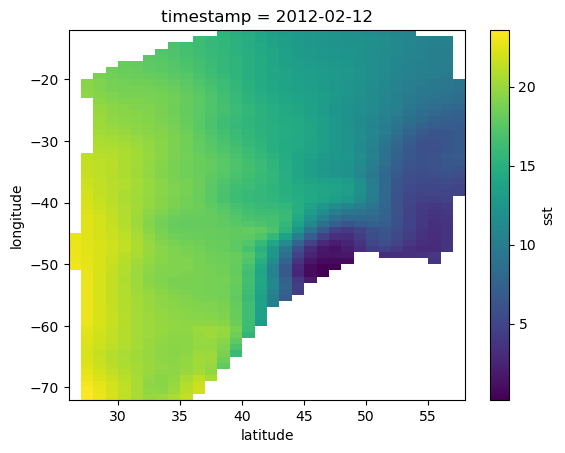

In [12]:
gridmap = ds.loc[{"timestamp":avh.parsetime('2012-02-12T00:00:00.000Z')}]
gridmap['sst'].plot()